In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install mne
!pip3 install mne_rsa
# !pip3 install eeglib
#!pip install tensorflow2.1
#!pip3 install protobuf3.10.0
%matplotlib inline

     |████████████████████████████████| 7.7 MB 14.8 MB/s 
  Created wheel for mne: filename=mne-1.0.1-py3-none-any.whl size=7542700 sha256=35c79411e4e63c9de3720b61da9fd5a363e0e4a9921f4f1d287d2c88ee152211
  Stored in directory: /root/.cache/pip/wheels/b1/16/e2/46ea7fb2215890e506fa85526ccbc2145663ad12c356d04c35
Successfully built mne


In [3]:
import os
import gc
import glob
import time
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sn
import itertools
import operator
import multiprocessing as mp

from tqdm import tqdm
from functools import partial
from PIL import Image

from scipy import stats
from scipy import signal

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import torch
import torchvision


import mne
import mne_rsa
from mne.baseline import rescale
from mne.filter import filter_data
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)
from mne.decoding import UnsupervisedSpatialFilter
from mne.time_frequency import tfr_morlet, tfr_array_morlet

#import eeglib

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import cm

from ipywidgets import interact

from sklearn.decomposition import PCA, FastICA
from sklearn.feature_selection import SelectKBest, RFE, chi2, mutual_info_classif, f_classif
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score,cross_val_predict, StratifiedKFold,KFold
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer, LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import label_binarize 

#from sklearn.externals import joblib

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score

from imblearn.under_sampling import ClusterCentroids
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline

import sys
sys.path.append('/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/NL_PCA')
from sklearn_nlpca import NLPCA

# **Funciones**

In [4]:
# Matriz de confusion
def plot_matriz_confusion(y_test, y_predict, labels, save=None, name_fig='fig_1.svg', file_directory='', titulo='Matriz de confusión', figsize = (7,5)):
  
    cm = confusion_matrix(y_test, y_predict)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100

    annot = np.empty_like(cm).astype(np.dtype('U30'))
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            
            s = cm_sum[i]
            annot[i, j] = '%.2f%%\n%d/%d\n' % (p, c, s)
            
              
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Estimados'
    cm.columns.name = 'Verdaderos'

    fig = plt.figure(figsize = figsize)
    fig.patch.set_facecolor('White')
    ax = fig.add_subplot(1,1,1)

    ax.set_title(titulo,fontdict={'weight': 'normal','size':20})
    ax.axhline(y=0, color='Black',linewidth=0.2)
    ax.axhline(y=2, color='Black',linewidth=0.2)
    ax.axvline(x=0, color='Black',linewidth=0.2)
    ax.axvline(x=2, color='Black',linewidth=0.2)

    sn.set(font_scale=1.2)  
    sn.heatmap(cm, cmap= "Blues", annot=annot, fmt='', linecolor='Black',linewidths=.1, cbar=None)

    if save==True:
        sns_plot = sn.heatmap(cm, cmap= "Blues", annot=annot, fmt='', linecolor='Black',linewidths=.1, cbar=None)
        fig = sns_plot.get_figure()
        fig.savefig(file_directory+name_fig)
        
# Matriz de confusion con rechazo
def plot_matriz_confusion_rechazo(y_test, y_predict, labels, save=None, name_fig='fig_1.svg', file_directory='', titulo='Matriz de confusión'):
  
    cm = confusion_matrix(y_test, y_predict)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if np.isnan(cm_perc[i][j]):
                cm_perc[i][j]=0
                

    annot = np.empty_like(cm).astype(np.dtype('U30'))
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            else:
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
              
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Verdaderos'
    cm.columns.name = 'Estimados'

    fig = plt.figure(figsize = (7,5))
    fig.patch.set_facecolor('White')
    ax = fig.add_subplot(1,1,1)

    ax.set_title(titulo,fontdict={'weight': 'normal','size':20})
    ax.axhline(y=0, color='Black',linewidth=0.2)
    ax.axhline(y=2, color='Black',linewidth=0.2)
    ax.axhline(y=3, color='Black',linewidth=0.2)
    ax.axvline(x=0, color='Black',linewidth=0.2)
    ax.axvline(x=2, color='Black',linewidth=0.2)
    ax.axvline(x=3, color='Black',linewidth=0.2)

    sn.set(font_scale=1.2)  
    sn.heatmap(cm, cmap= "Blues", annot=annot, fmt='', linecolor='Black',linewidths=.1, cbar=None)

    if save==True:
        sns_plot = sn.heatmap(cm, cmap= "Blues", annot=annot, fmt='', linecolor='Black',linewidths=.1, cbar=None)
        fig = sns_plot.get_figure()
        fig.savefig(file_directory+name_fig)
        
# Seleccion del folder actual
currentFolder = os.getcwd()

In [5]:
# Return X and y data from Epoched Dataframe
# X: EEG data, in format Ntrials x Nchannels X Nsamples
# y: labels
def getEEGXY(df, channels, columnClass, ColumnEpoch):
  import numpy as np
  classes = df[columnClass].unique()
  X = []
  y = []
  for label in classes:
    dfClass = df[df[columnClass]==label]
    epochs = dfClass[ColumnEpoch].unique()
    for epoch in epochs:
      dfEpoch = dfClass[dfClass[ColumnEpoch]==epoch]
      y.append(label)
      X.append(np.transpose(dfEpoch[channels].values))
  return np.stack(X,axis=0), np.array(y)

In [6]:
def extract_raw(path, subject, sesion, task, event_id):
  path_raw_file = path + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'

  targetPattern = path_raw_file + "*.vhdr"
  data_raw_file = glob.glob(targetPattern)
  raw = mne.io.read_raw_brainvision(data_raw_file[0], preload=True)
  channels = raw.info['ch_names']
  Fs = raw.info['sfreq']
  events, event_dict = mne.events_from_annotations(raw)
  event_dict = event_id
  
  
        
  return raw, Fs, events

In [7]:
def extract_df(path, subject, task, band='Alpha', sub=None):
  #Extract Data TRF
  sesions = ['01','02']
  dfs = []
  for sesion in sesions:
    if sub is None:
      Dir = path + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      df = pd.read_csv(Dir +'Time_frequency_decomposition_'+ band)
    else:
      Dir = path + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/Augmentation/'
      df = pd.read_csv(Dir +'Time_frequency_decomposition_'+ band + str(sub))
    dfs.append(df)
  df1,df2 = dfs[0],dfs[1]
  limite = np.array(df1['epoch'].values.tolist())[-1]
  df2['epoch'] = np.array(df2['epoch'].values.tolist())+limite
  df = pd.concat([df1, df2], axis=0)
  return df

In [8]:
# AUTHOR: KRISH KABRA
# Acknowledgment must be given to drewszurko: 
# github.com/drewszurko/tensorflow-WGAN-GP/blob/797e7c7c8c5861f3f55387635319972d9d224a8f/ops.py#L102

from tensorflow.keras import layers
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K 
from functools import partial
from tqdm import tqdm
from IPython.display import clear_output 
import time

class WGANGP(): 
  def __init__(self, eeg_img_shape, noise_dim=100,dropout=0.2):   
    # setup config variables eg. noise_dim, hyperparams, verbose, plotting etc. 
    self.noise_dim = noise_dim
    self.dropout = dropout
    self.eeg_img_shape = eeg_img_shape
        
    # setup history dictionary
    self.history = {}

    # build discriminator and generator models
    self.generator = self.build_generator()
    self.discriminator = self.build_discriminator()

  def build_generator(self):
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*11*512, use_bias=False, input_shape=(self.noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((4, 11, 512)))
    #assert model.output_shape == (None, 4, 11, 512) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 4), strides=(2, 2), padding='valid', use_bias=False))
    #assert model.output_shape == (None, 11, 24, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, (5, 4), strides=(2, 2), padding='valid', use_bias=False))
    #assert model.output_shape == (None, 25, 50, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 50, 100, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(5, (5, 5), strides=(1, 2), padding='same', use_bias=False, activation='tanh'))
    #assert model.output_shape == (None, 50, 200, 5)

    return model

  def build_discriminator(self):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=self.eeg_img_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(self.dropout))
    ##assert model.output_shape == (None,25,100,64) 

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(self.dropout)) # output = (25, 50, 128)
    #assert model.output_shape == (None,25,50,128) 

    model.add(layers.Flatten())
    model.add(layers.Dropout(self.dropout))
    model.add(layers.Dense(1))
    #assert model.output_shape == (None,1) 
    
    return model
  
  # generate fake data after training! 
  def generate_fake_data(self,N=100): 
    noise = tf.random.normal([N, self.noise_dim]).numpy()
    return generator(noise, training=False).numpy(), noise 
    
  # loss functions
  def disc_loss(self, fake_logits, real_logits):
    return tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)

  def gen_loss(self,fake_logits): 
    return - tf.reduce_mean(fake_logits)
  
  # gradient penalty term for discriminator 
  def gradient_penalty(self, discriminator, real_imgs, gen_imgs): 
    eps = tf.random.uniform([real_imgs.shape[0], 1, 1, 1], 0., 1.)
    inter = real_imgs + (eps * (real_imgs - gen_imgs))
    with tf.GradientTape() as tape: 
      tape.watch(inter)
      pred = discriminator(inter)
    
    grad = tape.gradient(pred,inter)[0]
    grad_l2_norm = tf.sqrt(tf.reduce_sum(tf.square(grad)))
    
    return tf.reduce_mean(grad_l2_norm) 

  # training functions
  # Notice the use of `tf.function`
  # This annotation causes the function to be "compiled".
  @tf.function
  def train_step(self,images):
    
    # loss variables to return
    disc_loss, disc_grads = 0,0
    
    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    # train discriminator over several iterations 
    for _ in range(self.discriminator_iters):
      # setup gradient tools -- GradientTape automatically watches all trainable variables 
      with tf.GradientTape() as disc_tape:
        # forward prop
        noise = tf.random.normal([images.shape[0], self.noise_dim])
        gen_imgs = self.generator(noise, training=True)
        print("Aqui")
        fake_logits = self.discriminator(gen_imgs, training=True)
        real_logits = self.discriminator(images, training=True)
        
        # calculate loss
        loss = self.disc_loss(fake_logits,real_logits)
        gp = self.gradient_penalty(partial(self.discriminator, training=True), images, gen_imgs)
        loss += self.gp_weight * gp 
    
      # back prop      
      disc_grads = disc_tape.gradient(loss, self.discriminator.trainable_variables)
      self.discriminator_optimizer.apply_gradients(zip(disc_grads,self.discriminator.trainable_variables))
      
      # save some variables for history 
      disc_loss += loss
      disc_grads += disc_grads
    print("Aqui")
    # ---------------------
    #  Train Generator 
    # ---------------------
    noise = tf.random.normal([images.shape[0], self.noise_dim])
    with tf.GradientTape() as gen_tape:
      gen_imgs = self.generator(noise, training=True)
      fake_logits = self.discriminator(gen_imgs, training=True)
      gen_loss = self.gen_loss(fake_logits)

    gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
    self.generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
    
    return disc_loss, disc_grads[0], gen_loss, gen_grads[0]

  # training loop
  def train(self, train_dataset, generator_optimizer, discriminator_optimizer, 
            epochs=25, batch_size=128, discriminator_iters=5,
            gp_weight=0, plot=False, save_plots=False):
    '''
    Training loop
    INPUTS: 
    dataset - EEG training dataset as numpy array with shape=(trials,eeg,freq_bins,time_bins)
    '''

    # set up data for training
    dataset = tf.data.Dataset.from_tensor_slices(train_dataset.astype('float32')).shuffle(train_dataset.shape[0]).batch(batch_size)
    N_batch = np.ceil(train_dataset.shape[0]/float(batch_size))

    # save optimizers
    self.generator_optimizer = generator_optimizer
    self.discriminator_optimizer = discriminator_optimizer

    # save training variables 
    self.discriminator_iters = discriminator_iters
    self.gp_weight = gp_weight

    # setup history variables 
    history = self.history
    history['grads'], history['loss']= {}, {}
    gen_loss_history, disc_loss_history = [],[]
    gen_grads_history, disc_grads_history= [],[]
    
    # start training loop
    for epoch in range(epochs):
      start = time.time()
      
      # refresh loss for every epoch 
      gen_loss, disc_loss, disc_grads, gen_grads = 0, 0, 0, 0
     
      with tqdm(total=N_batch, position=0, leave=True) as pbar:
        for image_batch in dataset:
          print(len(image_batch))
          # train step           
          disc_loss_batch, disc_grads_batch, gen_loss_batch, gen_grads_batch = self.train_step(image_batch)   
          
          # convert variables to usable format
          disc_loss_batch = tf.reduce_mean(disc_loss_batch).numpy()/float(self.discriminator_iters)
          disc_grads_batch = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(disc_grads_batch)))).numpy()/float(self.discriminator_iters)
          gen_loss_batch = tf.reduce_mean(gen_loss_batch).numpy()
          gen_grads_batch = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(gen_grads_batch)))).numpy()
          
          # store history 
          gen_loss += gen_loss_batch/float(N_batch)
          disc_loss += disc_loss_batch/float(N_batch)
          gen_grads += gen_grads_batch/float(N_batch)
          disc_grads += disc_grads_batch/float(N_batch)

          pbar.update()
      pbar.close()
      
      # store history 
      gen_loss_history.append(gen_loss)
      disc_loss_history.append(disc_loss)
      gen_grads_history.append(gen_grads)
      disc_grads_history.append(disc_grads) 
      

      print ('Epoch #: {}/{}, Time taken: {} secs,\n Grads: disc= {}, gen= {},\n Losses: disc= {}, gen= {}'\
             .format(epoch+1,epochs,time.time()-start, disc_grads, gen_grads, disc_loss, gen_loss))

      if plot and epoch % 20 == 0: 
        # fake image example
        generated_image, _ = self.generate_fake_data(N=1)       
        # real image example  
        trial_ind, eeg = 0, 0
        real_image = np.expand_dims(train_dataset[trial_ind], axis=0)
        
        # visualize fake and real data examples
        plt.figure()
        plt.subplot(121)
        plt.imshow(generated_image[0, :, :, eeg], aspect='auto')
        plt.colorbar()
        plt.title('Fake decision, eeg {}:\n {}'.format(eeg, self.discriminator(generated_image).numpy()))
        plt.subplot(122)
        plt.imshow(real_image[0,:,:,eeg], aspect='auto')
        plt.title('Real decision, trial {}, eeg {}:\n {}'.format(trial_ind, eeg, self.discriminator(real_image).numpy()))
        plt.colorbar()
        plt.subplots_adjust(hspace=0.5)
        plt.show()

        # plot discriminator classification
        gen_imgs, _ = self.generate_fake_data(N=train_dataset.shape[0])
        fake_predictions = self.discriminator(gen_imgs)
        real_predictions = self.discriminator(train_dataset)
        plt.figure()
        plt.plot(real_predictions.numpy(),'bo')
        plt.plot(fake_predictions.numpy(),'ro')
        plt.legend(['Real', 'Fake'])
        plt.show()

    # Generate after the final epoch
    clear_output(wait=True)
    
    plt.figure()
    plt.plot(gen_loss_history, 'r')
    plt.plot(disc_loss_history, 'b')
    plt.title('Loss history')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Generator', 'Discriminator'])
    plt.show()

    plt.figure()
    plt.plot(gen_grads_history, 'r')
    plt.plot(disc_grads_history, 'b')
    plt.title('Gradient history')
    plt.xlabel('Epochs')
    plt.ylabel('Gradients (L2 norm)')
    plt.legend(['Generator', 'Discriminator'])
    plt.show()

    history['grads']['gen'], history['grads']['disc'] = gen_grads_history, disc_grads_history
    history['loss']['gen'], history['loss']['disc'] = gen_loss_history, disc_loss_history   
    
    self.history = history
    
    return history    

In [9]:
def Conv_Block():
  model = models.Sequential()
  #model.add(data_augmentation)
  model.add(layers.Conv2D(64, 5, (1, 1), padding='same', activation='relu', input_shape=input_shape[1:]))
  model.add(layers.AveragePooling2D((3, 3)))
  model.add(layers.Conv2D(64, 5, (1, 1), padding='same', activation='relu'))
  model.add(layers.AveragePooling2D((2, 2)))
  model.add(layers.Conv2D(128, 5, (1, 1), padding='same', activation='relu'))
  model.add(layers.AveragePooling2D((2, 2)))
  model.add(layers.Conv2D(128, 4, (1, 1), padding='same', activation='relu'))

  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  #model.add(layers.Dropout(0.15))
  model.add(layers.Dense(128, activation='relu'))
  #model.add(layers.Dropout(0.15))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(1, activation='softmax'))

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
class ScalerMinMax(TransformerMixin, BaseEstimator):

    def __init__(self, info=None, feature_range=(0, 1)):  # noqa: D102
        self.info = info
        self.feature_range = feature_range

        self._scaler = MinMaxScaler(feature_range=self.feature_range)



    def fit(self, epochs_data, y=None):
        """Standardize data across channels.

        Parameters
        ----------
        epochs_data : array, shape (n_epochs, n_channels, n_times)
            The data to concatenate channels.
        y : array, shape (n_epochs,)
            The label for each epoch.

        Returns
        -------
        self : instance of Scaler
            The modified instance.
        """
        # _validate_type(epochs_data, np.ndarray, 'epochs_data')
        if epochs_data.ndim == 2:
            epochs_data = epochs_data[..., np.newaxis]
        assert epochs_data.ndim == 3, epochs_data.shape
        self._sklearn_reshape_apply(self._scaler.fit, False, epochs_data, y=y)
        return self


    def transform(self, epochs_data):
        """Standardize data across channels.

        Parameters
        ----------
        epochs_data : array, shape (n_epochs, n_channels[, n_times])
            The data.

        Returns
        -------
        X : array, shape (n_epochs, n_channels, n_times)
            The data concatenated over channels.

        Notes
        -----
        This function makes a copy of the data before the operations and the
        memory usage may be large with big data.
        """
        #_validate_type(epochs_data, np.ndarray, 'epochs_data')
        if epochs_data.ndim == 2:  # can happen with SlidingEstimator
            if self.info is not None:
                assert len(self.info['ch_names']) == epochs_data.shape[1]
            epochs_data = epochs_data[..., np.newaxis]
        assert epochs_data.ndim == 3, epochs_data.shape
        return self._sklearn_reshape_apply(self._scaler.transform, True,
                                      epochs_data)


    def fit_transform(self, epochs_data, y=None):
        """Fit to data, then transform it.

        Fits transformer to epochs_data and y and returns a transformed version
        of epochs_data.

        Parameters
        ----------
        epochs_data : array, shape (n_epochs, n_channels, n_times)
            The data.
        y : None | array, shape (n_epochs,)
            The label for each epoch.
            Defaults to None.

        Returns
        -------
        X : array, shape (n_epochs, n_channels, n_times)
            The data concatenated over channels.

        Notes
        -----
        This function makes a copy of the data before the operations and the
        memory usage may be large with big data.
        """
        return self.fit(epochs_data, y).transform(epochs_data)


    def inverse_transform(self, epochs_data):
        """Invert standardization of data across channels.

        Parameters
        ----------
        epochs_data : array, shape (n_epochs, n_channels, n_times)
            The data.

        Returns
        -------
        X : array, shape (n_epochs, n_channels, n_times)
            The data concatenated over channels.

        Notes
        -----
        This function makes a copy of the data before the operations and the
        memory usage may be large with big data.
        """
        assert epochs_data.ndim == 3, epochs_data.shape
        return self._sklearn_reshape_apply(self._scaler.inverse_transform, True,
                                      epochs_data)
    
    def _sklearn_reshape_apply(self,func, return_result, X, *args, **kwargs):
      """Reshape epochs and apply function."""
      if not isinstance(X, np.ndarray):
          raise ValueError("data should be an np.ndarray, got %s." % type(X))
      orig_shape = X.shape
      X = np.reshape(X.transpose(0, 2, 1), (-1, orig_shape[1]))
      X = func(X, *args, **kwargs)
      if return_result:
          X.shape = (orig_shape[0], orig_shape[2], orig_shape[1])
          X = X.transpose(0, 2, 1)
          return X

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import  check_is_fitted
class Reduction_Time(BaseEstimator, TransformerMixin):

  def _more_tags(self):
    return {'non_deterministic': True, '_skip_test':True,
      '_xfail_checks': {
                'check_methods_subset_invariance':
                'fails for the transform method'
            }
        }

  def __init__(self, sfreq, t0=-0.6,tmin=0.0,tmax=2.0):
    self.sfreq = sfreq
    self.t0 = t0
    self.tmin = tmin
    self.tmax = tmax
  
  def fit(self, X, y=None):
    # Check that X and y have correct shape
    

    return self


  def transform(self, X):

    t0 = self.t0            
    tmin = self.tmin
    tmax = self.tmax

    
    print('Reduction time')
    p0 = int((tmin + (-t0))*(self.sfreq))
    p1 = int((tmax + (-t0))*(self.sfreq))+1
    X = X[:,:,p0:p1]

    self.X_ = X
    self.y_ = y

    
    return X
  
  def fit_transform(self, X, y):
    
    self.fit(X, y)
    
    y_ = self.transform(X)
    return y_ 



In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import  check_is_fitted
class Temporal_Filter_Reduce(BaseEstimator, TransformerMixin):

  def _more_tags(self):
    return {'non_deterministic': True, '_skip_test':True,
      '_xfail_checks': {
                'check_methods_subset_invariance':
                'fails for the transform method'
            }
        }

  def __init__(self, estimator):
    self.estimator=estimator
  
  def fit(self, X, y=None):
    # Check that X and y have correct shape

    X_ = X.swapaxes(1,2) #Dimension temporal eje 2

    self.Filter = UnsupervisedSpatialFilter(self.estimator, average=False)
    self.Filter.fit(X_,y)

    return self


  def transform(self, X):

    X_ = X.swapaxes(1,2)

    X_ = self.Filter.transform(X_)
    X_ = X_.swapaxes(1,2) #Dimension temporal eje 2
    print('Xtemporal:==>'+str(X_.shape))
    return X_
  
  def fit_transform(self, X, y):
    
    self.fit(X, y)
    
    y_ = self.transform(X)
    return y_ 

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from mne.decoding import Vectorizer
class ExtrationFeatures(BaseEstimator, TransformerMixin):

  def _more_tags(self):
    return {'non_deterministic': True, '_skip_test':True,
      '_xfail_checks': {
                'check_methods_subset_invariance':
                'fails for the transform method'
            }
        }

  def __init__(self, sfreq, t0, tmin=0.0,tmax=1.0,features=(['logVar','Entropy','Energy','LBP'])):
    self.sfreq = sfreq
    self.t0 = t0
    self.features = features
    self.tmin = tmin
    self.tmax = tmax
  
  def fit(self, X, y):
    # Check that X and y have correct shape
    self._check_Xy(X, y)
    check_classification_targets(y)

    # Store the classes seen during fit
    self.classes_ = np.unique(y)

    self.expected_n_features_ = X.shape[1]

    return self


  def transform(self, X):
    
    check_is_fitted(self)
    # Check that X and y have correct shape
    # vect = Vectorizer()
    # X_ = vect.fit_transform(X)

    # if X_.dtype is not 'complex128':
    #   X_ = check_array(X_)

    n_features = X.shape[1]
    
    expected_n_features = self.expected_n_features_

    if n_features != expected_n_features:
                raise ValueError("Input has n_features=%d while the model"
                                 " has been trained with n_features=%d" % (
                                     n_features, expected_n_features))


    t0 = self.t0            
    tmin = self.tmin
    tmax = self.tmax
    
    if t0 is not None and tmin is not None and tmax is not None:
      print('Reduction time')
      p0 = int((tmin + (-t0))*(self.sfreq))
      p1 = int((tmax + (-t0))*(self.sfreq))+1
      X = X[:,:,p0:p1]

    self.X_ = X
    self.y_ = y

    
    return self._features_func(X)
  
  def fit_transform(self, X, y):
    
    self.fit(X, y)
    
    y_ = self.transform(X)
    return y_ 
  
  def _logVar(self,X):
    print(X.shape)
    Var = np.var(X,axis=-1)
    print(Var.shape)
    m_Var = np.sum(Var,axis=-1, keepdims=True)
    div = Var/m_Var
    print('Shape logVar:'+str(div.shape))
    return np.log10(div,where=True)
  
  def _Entropy(self,X):
    Power = np.abs(X)**2
    logPower = np.log10(Power)
    product = np.multiply(Power,logPower)
    return np.sum(product,axis=-1)

  def _eeglib_features(self,X,argument):
    xx = np.zeros(X.shape[-1])
    # switcher_func = {
    #   'SampleEntropy' : eeglib.features.sampEn(xx),
    #   'DFA' : eeglib.features.DFA(xx,max_window_size=10),
    #   'HFD' : eeglib.features.HFD(xx),
    #   'PFD' : eeglib.features.PFD(xx),
    #   'LZC' : eeglib.features.LZC(xx),
    #   'Activity_Hjorth' : eeglib.features.hjorthActivity(xx),
    #   'Complexity_Hjorth' : eeglib.features.hjorthComplexity(xx),
    #   'Mobility_Hjorth' : eeglib.features.hjorthMobility(xx)
    # }

    feeg = np.zeros(X.shape[0:2])

    # for e in range(len(X)):
    #   E = X[e]
    #   for c in range(len(E)):
    #     xx = E[c]
    #     feeg[e,c] = switcher_func.get(argument)

    return feeg



  def _features_func(self,X):
    print('Input: '+ str(X.shape))
    print('Features: '+ str(self.features))
    if len(X.shape) == 2:
      dims = True
    else:
      dims = False
    

    switcher_feature = {
        'Var' : np.var(X,axis=-1, keepdims=dims),
        'Std' : np.std(X,axis=-1, dtype=float, keepdims=dims),
        'Mean' : np.mean(X,axis=-1, keepdims=dims),
        'Max' : np.max(X,axis=-1, keepdims=dims),
        'Min' : np.min(X,axis=-1, keepdims=dims),
        'logVar' : np.log10(np.var(X,axis=-1, keepdims=dims),where=True),
        'logVar_normalized': self._logVar(X),
        'Skew' : stats.skew(np.array(X,dtype='float64'), axis=-1),
        'Kurtosis' : scipy.stats.kurtosis(X, axis=-1),
        'gmean' : scipy.stats.gmean(X, axis=-1),
        'moment' : scipy.stats.moment(X, axis=-1),
        'RMS' : np.sqrt(np.mean(X**2,axis=-1, keepdims=dims),where=False),
        'MAV' : np.mean(np.abs(X),axis=-1, keepdims=dims),
        'SSI' : np.sum(np.abs(X)**2,axis=-1, keepdims=dims),
        'WL' : np.sum(np.abs(np.diff(X,axis=-1)), axis=-1, keepdims=dims),
        'Dense': np.sum(X,axis=-1, keepdims=dims),
        'Energy' : np.sum(np.abs(X)**2,axis=-1, keepdims=dims),
        'Power' : np.mean(np.abs(X)**2,axis=-1, keepdims=dims),
        'LBP' : np.log10(np.mean(np.abs(X)**2,axis=-1, keepdims=dims)),
        'logPower' : np.mean(np.log10(np.abs(X)**2),axis=-1, keepdims=dims),
        'Entropy' : self._Entropy(X),
        'SampleEntropy' : self._eeglib_features(X,'SampleEntropy'),
        'DFA' : self._eeglib_features(X,'DFA'),
        'HFD' : self._eeglib_features(X,'HFD'),
        'PFD' : self._eeglib_features(X,'PFD'),
        'LZC' : self._eeglib_features(X,'LZC'),
        'Activity_Hjorth' : self._eeglib_features(X,'Activity_Hjorth'),
        'Complexity_Hjorth' : self._eeglib_features(X,'Complexity_Hjorth'),
        'Mobility_Hjorth' : self._eeglib_features(X,'Mobility_Hjorth')
        }
    
    # MAD = stats.median_absolute_deviation(X, axis=-1)
    #diff_entropy = stats.differential_entropy(X, axis=-1, window_length=1)
    # if len(X.shape) == 2:
    #   Skew = np.array(Skew, ndmin=2).T
    #   Kurtosis = np.array(Kurtosis, ndmin=2).T
    #   MAD = np.array(MAD, ndmin=2).T
    list_features = []
    features = self.features
    print(features)
    for argument in features:
      # print('argument ' + argument)
      list_features.append(switcher_feature.get(argument))
      # func = switcher_feature.get(argument)
      # print(func.shape)
      # print(np.any(np.isnan(func)))
      # print(np.all(np.isfinite(func)))
    if len(list_features) == 1:
      list_features = np.array(list_features[0])
    else:
      list_features = np.hstack(list_features)
    # print(np.any(np.isnan(list_features)))
    # print(np.all(np.isfinite(list_features)))
    # print(list_features.shape)
    list_features = np.nan_to_num(list_features)
    print(list_features.dtype)
    print(list_features.shape)
    return list_features

  
  def _check_Xy(self, X, y=None):
    """Aux. function to check input data."""
    if y is not None:
      if len(X) != len(y) or len(y) < 1:
        raise ValueError('X and y must have the same length.')
      if X.ndim < 3:
        raise ValueError('X must have at least 3 dimensions.')
  

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from mne.filter import filter_data
from mne.decoding import Vectorizer
class Data_Filter(BaseEstimator, TransformerMixin):

  def _more_tags(self):
    return {'non_deterministic': True, '_skip_test':True,
      '_xfail_checks': {
                'check_methods_subset_invariance':
                'fails for the transform method'
            }
        }

  def __init__(self, sfreq, l_freq, h_freq, times, baseline=None, n_jobs=1):
    self.sfreq = sfreq
    self.l_freq = l_freq
    self.h_freq = h_freq
    self.times = times
    self.baseline = baseline
    self.n_jobs = n_jobs
  
  def fit(self, X, y):
    # Check that X and y have correct shape
    self._check_Xy(X, y)
    check_classification_targets(y)

    # Store the classes seen during fit
    self.classes_ = np.unique(y)

    self.expected_n_features_ = X.shape[1]

    return self


  def transform(self, X):
    
    check_is_fitted(self)
    # Check that X and y have correct shape
    # vect = Vectorizer()
    # X_ = vect.fit_transform(X)

    # if X_.dtype is not 'complex128':
    #   X_ = check_array(X_)

    n_features = X.shape[1]
    
    expected_n_features = self.expected_n_features_

    if n_features != expected_n_features:
                raise ValueError("Input has n_features=%d while the model"
                                 " has been trained with n_features=%d" % (
                                     n_features, expected_n_features))
                            
    X = filter_data(X, sfreq=self.sfreq, l_freq=self.l_freq, h_freq=self.h_freq, n_jobs=self.n_jobs,
                           method='iir', iir_params=dict(order=5, ftype='butter', output='sos'))
    
    # X = filter_data(X, sfreq=self.sfreq, l_freq=self.l_freq, h_freq=self.h_freq, n_jobs=self.n_jobs,
    #                        method='fir')
    
    gc.collect()
    if self.baseline is not None:
      X = rescale(X, self.times, baseline=self.baseline)
    gc.collect()
    return X
  
  def fit_transform(self, X, y):
    
    self.fit(X, y)
    
    y_ = self.transform(X)
    return y_ 
  

  def _check_Xy(self, X, y=None):
    """Aux. function to check input data."""
    if y is not None:
      if len(X) != len(y) or len(y) < 1:
        raise ValueError('X and y must have the same length.')
      if X.ndim < 3:
        raise ValueError('X must have at least 3 dimensions.')

In [15]:
from mne.stats import permutation_cluster_test, permutation_t_test
from sklearn.base import BaseEstimator, TransformerMixin
class select_channel_stats(TransformerMixin, BaseEstimator):


  def __init__(self, epochs, band, n_permutations=50000,n_jobs=-1):

    self.epochs = epochs
    self.band = band
    self.n_permutations = n_permutations
    self.n_jobs = n_jobs
  
  def fit_transform(self, X, y=None):

    self.fit(X)

    return self.transform(X)
  
  def fit(self, X, y=None):

    picks = mne.pick_types(self.epochs.info,eeg=True)


    times = self.epochs.times

    data = np.mean(X[:, :, :], axis=2)

    n_permutations = self.n_permutations
    T0, p_values, H0 = permutation_t_test(data, n_permutations, n_jobs=self.n_jobs)
    
    self._significant_sensors = picks[p_values <= 0.05]
    #  print(significant_sensors)
    self.significant_sensors_names = [epochs.ch_names[k] for k in self._significant_sensors]
    
    print("Number of significant sensors : %d" % len(self._significant_sensors))
    print("Sensors names : %s" % self.significant_sensors_names)
    print('\n')

    evoked = mne.EvokedArray(-np.log10(p_values)[:, np.newaxis],
                         self.epochs.info, tmin=0.0)

    # Extract mask and indices of active sensors in the layout
    stats_picks = mne.pick_channels(evoked.ch_names, self.significant_sensors_names)
    mask = p_values[:, np.newaxis] <= 0.05

    evoked.plot_topomap(ch_type='eeg', times=[0], scalings=1,
                    time_format=None, cmap='Reds', vmin=0., vmax=np.max,
                    units='-log10(p)', cbar_fmt='-%0.1f', mask=mask,
                    size=5, show_names=True,
                    time_unit='s')
    
  def transform(self, X):

    Xt = X[:,self._significant_sensors,:]

    return Xt

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import copy
class select_channel_csp(TransformerMixin, BaseEstimator):


  def __init__(self, epochs, band, sfreq, csp, select=None,t0=None, tmin=None, tmax=None, cut=False, draw=False, filtre=False, n_jobs=-1):

    self.epochs = epochs
    self.band = band
    self.sfreq = sfreq
    self.csp = csp
    self.select = select
    self.t0 = t0
    self.tmin = tmin
    self.tmax = tmax
    self.cut = cut
    self.draw = draw
    self.filtre = filtre
    self.n_jobs = n_jobs
  
  def fit_transform(self, X, y):

    self.fit(X,y)

    return self.transform(X)
  
  def fit(self, X, y):
    print('Shape Xnormal:'+str(X.shape))

    if filtre is True:

      iter_freqs = {
      'Delta': (1, 4),
      'Theta': (5, 7),
      'Alpha': (8, 13),
      'Beta': (14, 31),
      'Gamma': (32, 64)
      }

      freqs = iter_freqs.get(self.band)
      l_freq=freqs[0]
      h_freq=freqs[1]

      Xcopy = filter_data(X, sfreq=self.sfreq, l_freq=l_freq, h_freq=h_freq, n_jobs=self.n_jobs,
                           method='fir')
      
    t0 = self.t0            
    tmin = self.tmin
    tmax = self.tmax
    cut = self.cut
    window = None
    
    if t0 is not None and tmin is not None and tmax is not None:
      window = tmax-tmin
      print('Reduction time')
      p0 = int((tmin + (-t0))*(self.sfreq))
      p1 = int((tmax + (-t0))*(self.sfreq))+1
      if filtre is True:
        Xcopy = Xcopy[:,:,p0:p1]
      else:
        Xcopy = X[:,:,p0:p1]
    else:
      if filtre is True:
        Xcopy = Xcopy
      else:
        Xcopy = X
    
    if cut is True:
      X = Xcopy
    else:
      Xcopy = X
    
    
    # scaler = Scaler(epochs.info,scalings='mean')
    # print('Shape Xcopy:'+str(Xcopy.shape))
    # Xcopy = scaler.fit_transform(Xcopy)

    print('\nSelect channel from band '+ self.band)
    print(self.csp.get_params())
    self.csp.fit(Xcopy,y)
    W = self.csp.filters_.T
    n_components = self.csp.get_params().get('n_components')
    wn = W[:,:n_components]
    #del self.csp
    gc.collect()

    l1W = np.linalg.norm(W,1)
    SC = []
    for wi in wn:
      #print(wi.shape)
      l1 = np.linalg.norm(wi,1)
      SCn = l1/l1W
      #print(SCn)
      SC.append(SCn)
    SC = np.array(SC)
    gc.collect()
    sensors = np.argsort(SC)[::-1]
    print(sensors)
    SCi = SC[sensors]
    print(SCi)
    if self.select is None:
      umbral = np.mean(SCi)
      print(umbral)
      self._significant_sensors = sensors[SCi >= umbral]
    else:
      self._significant_sensors = sensors[:self.select]
    
    self.significant_sensors_names = [self.epochs.ch_names[k] for k in self._significant_sensors]
    # del self.epochs
    print(self.significant_sensors_names)

    gc.collect()

    epochs_copy = self.epochs.copy()
    # if window is not None:
    #   epochs_copy.info['sfreq']=1/window

    self.data = np.array(SC,ndmin=2).T
    self.evoked = mne.EvokedArray(self.data,epochs_copy.info, tmin=self.tmin)
    self.mask = self.data >= np.mean(SC)
    #self.mask = self.evoked.data >= np.mean(SC)

    if self.draw is True:
      self.evoked.plot_topomap(ch_type='eeg', times=[self.tmin], scalings=1,
                     time_format=None, cmap='RdYlBu_r', vmin=SC.min(), vmax=SC.max(),
                     units='SC', cbar_fmt='%0.2f',size=5, show_names=True,
                     time_unit='s', mask=self.mask)

    gc.collect()
    
  def transform(self, X):

    t0 = self.t0            
    tmin = self.tmin
    tmax = self.tmax
    cut = self.cut

    if t0 is not None and tmin is not None and tmax is not None and cut is True:
      print('Reduction time')
      p0 = int((tmin + (-t0))*(self.sfreq))
      p1 = int((tmax + (-t0))*(self.sfreq))+1
      Xt = X[:,:,p0:p1]
      print('Hecho')
    else:
      Xt = X[:,:,:]

    Xt = Xt[:,self._significant_sensors,:]
    print('Ouput select channel CSP: '+str(Xt.shape))
    return Xt

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
from mne.decoding import Vectorizer

class inverse_vectorizer(TransformerMixin, BaseEstimator):

  def __init__(self,vect):
    self.vect = vect
  
  def fit_transform(self, X, y=None):

    self.fit(X,y)

    return self.transform(X)
  
  def fit(self, X, y=None):

    return self

  def transform(self, X, y=None):
    
    Xt = self.vect.inverse_transform(X)
    return Xt

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
from mne.decoding import Vectorizer
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

class resample_vectorizer(TransformerMixin, BaseEstimator):

  def __init__(self,random_state=0):
    self.random_state = random_state
    
  
  def fit(self, X, y):

    self._rus = RandomUnderSampler(random_state=self.random_state)
    self._vect = Vectorizer()

  def fit_resample(self, X, y):
    print(X.shape)
    _Xvect = self._vect.fit_transform(X,y)
    print(_Xvect.shape)
    _Xresample, _yresample = self._rus.fit_resample(_Xvect,y)
    print(_Xresample.shape)
    _Xnew = self._vect.inverse_transform(_Xresample)
    print(_Xnew.shape)
    return _Xnew

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import label_binarize
from mne.decoding import (Vectorizer,CSP,Scaler)
from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
import copy


# clf = OneVsRestClassifier(pipe)
class CSPOVR(TransformerMixin, BaseEstimator):


  def __init__(self, epochs, sfreq, n_components=4, reg=None, log=None, cov_est='concat', transform_into='average_power', 
               norm_trace=False, cov_method_params=None, rank=None, component_order='mutual_info', info=None,
               t0=None, tmin=None, tmax=None, cut=False, draw=False, filtre=False):

    self.n_components = n_components
    self.reg = reg
    self.log = log
    self.cov_est = cov_est
    self.transform_into = transform_into
    self.norm_trace = norm_trace
    self.cov_method_params = cov_method_params
    self.rank = rank
    self.component_order = component_order
    self.info = info

    self.epochs = epochs
    self.band = band
    self.sfreq = sfreq
    self.t0 = t0
    self.tmin = tmin
    self.tmax = tmax
    self.cut = cut
    self.draw = draw
    self.filtre = filtre


    self.csp = CSP(n_components, reg, log, cov_est, transform_into, norm_trace, cov_method_params, rank, component_order)
    self.select = select_channel_csp(epochs, band='full', sfreq=sfreq, csp=csp, t0=t0, tmin=tmin, tmax=tmax, draw=draw, filtre=filtre)
    self.reduction = Reduction_Time(sfreq=sfreq, t0=t0, tmin=tmin, tmax=tmax)
  
  def fit_transform(self, X, y):

    self.fit(X,y)

    return self.transform(X)
  
  def fit(self, X, y):
     
    self._scale = Scaler(info=self.info, scalings='mean', with_mean=True, with_std=True)
    _rus = RandomUnderSampler(random_state=0)
    _vect = Vectorizer()
    list_csp = []

    _classes = np.unique(y)
    _ybi = label_binarize(y, classes=_classes)
    _Xscaler = self._scale.fit_transform(X)
    _Xvect = _vect.fit_transform(_Xscaler,y)

    for _yi, c in zip(_ybi.T,_classes):
      _Xresample,_yresample = _rus.fit_resample(_Xvect,_yi)
      _Xnew = _vect.inverse_transform(_Xresample)
      pipe = make_pipeline(self.select, self.reduction, self.csp)
      pipe.fit(_Xnew,_yresample)
      _csp = copy.deepcopy(pipe)
      class_csp = "csp_"+str(c)
      list_csp.append((class_csp,_csp))
      
    
    self.csp_ovr = FeatureUnion(list_csp)
           
  def transform(self, X):

    _Xscaler = self._scale.transform(X)
    Xt = self.csp_ovr.transform(_Xscaler)
    return Xt

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
import copy
class csp_time(TransformerMixin, BaseEstimator):


  def __init__(self, epochs, csp, sfreq, t0=None, tmin=None, tmax=None):

    self.epochs = epochs
    self.csp = copy.deepcopy(csp)
    self.sfreq = sfreq
    self.t0 = t0
    self.tmin = tmin
    self.tmax = tmax
  
  def fit_transform(self, X, y):

    self.fit(X,y)

    return self.transform(X)
  
  def fit(self, X, y):
      
    t0 = self.t0            
    tmin = self.tmin
    tmax = self.tmax
    
    if t0 is not None and tmin is not None and tmax is not None:
      print('Reduction time')
      p0 = int((tmin + (-t0))*(self.sfreq))
      p1 = int((tmax + (-t0))*(self.sfreq))+1
      Xcopy = X[:,:,p0:p1]
    else:
      Xcopy = X
    
    self._scaler = Scaler(epochs.info,scalings='mean')
    Xcopy = self._scaler.fit_transform(Xcopy)

    self.csp.fit(Xcopy,y)
    gc.collect()
    
  def transform(self, X):

    X = self._scaler.transform(X)
    print('Shape of CSP_Time: '+str(X.shape))
    Xt = self.csp.transform(X)

    return Xt

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import copy
class epoch_time_csp(TransformerMixin, BaseEstimator):


  def __init__(self, epochs, band, sfreq, csp, vect, t0=None, tmin=None, tmax=None, window=None, draw=False, filtre=False, n_jobs=-1):

    self.epochs = epochs
    self.band = band
    self.sfreq = sfreq
    self.csp = csp
    self.vect = vect
    self.t0 = t0
    self.tmin = tmin
    self.tmax = tmax
    self.window = window
    self.draw = draw
    self.filtre = filtre
    self.n_jobs = n_jobs
  
  def fit_transform(self, X, y):
    
    self.fit(X,y)

    return self.transform(X)
  
  def fit(self, X, y):
    
    X = self.vect.inverse_transform(X)

    div = int((self.tmax-self.tmin)/self.window)
    tmin = self.tmin
    str_scc = 'SCC_CSP'
    times = []
    transformer_list = []
    scaler_list = []
    SCC_list = []
    csp_list = []
    for e in range(div):
      tmax = tmin + self.window
      print('Tiempos:'+str(tmin)+'-'+str(tmax))

      scaler = Scaler(epochs.info,scalings='mean')
      print('\nFor band '+ self.band)
      SCC = select_channel_csp(epochs=self.epochs, band=self.band, sfreq=self.sfreq, csp=self.csp,
                       t0=self.t0, tmin=tmin, tmax=tmax, cut=True, draw=False, filtre=self.filtre)
      print('\nCSP band '+ self.band)
      csp_window = self.csp
      #csp_window = csp_time(epochs=self.epochs,csp=self.csp, sfreq=self.sfreq, t0=self.t0, tmin=self.tmin, tmax=self.tmax)
      
      scaler_copy = copy.deepcopy(scaler)
      SCC_copy = copy.deepcopy(SCC)
      csp_copy = copy.deepcopy(csp_window)
      scaler_list.append(scaler_copy)
      SCC_list.append(SCC_copy)
      csp_list.append(csp_copy)

      SCC_CSP = make_pipeline(scaler_copy,SCC_copy,csp_copy)

      str_c = str_scc + '_' + str(e+1)
      containing = (str_c,SCC_CSP)
      transformer_list.append(containing)
      times.append(tmin)
      tmin = tmax
    
    times = np.array(times)
    self.union = FeatureUnion(transformer_list)
    self.union.fit(X,y)

    if self.draw is True:
      data = []
      mask = []
      for SCC in SCC_list:
        data.append(SCC.data)
        mask.append(SCC.mask)
      data = np.array(data)
      mask = np.array(mask)
      print('MASK'+str(mask.shape))

      data = np.concatenate(data, axis=1)
      mask = np.concatenate(mask, axis=1)

      epochs_copy = self.epochs.copy()
      epochs_copy.info['sfreq']=1/self.window

      evoked = mne.EvokedArray(data,epochs_copy.info, tmin=0.0)
      print(self.tmin)
      print(tmax)
      print(epochs_copy.info['sfreq'])
      print(data.shape)
      print(mask.shape)
      print(times)
      evoked.plot_topomap(ch_type='eeg', times=[0.0,1.0], scalings=1,
                     time_format=None, cmap='RdYlBu_r', vmin=data.min(), vmax=data.max(),
                     units='SC', cbar_fmt='%0.2f',size=4, show_names=True,
                     time_unit='s', mask=mask)

    gc.collect()
    
  def transform(self, X):

    X = self.vect.inverse_transform(X)

    Xt = self.union.transform(X)

    return Xt

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import copy
class epoch_time_csp_select(TransformerMixin, BaseEstimator):


  def __init__(self, epochs, band, sfreq, csp, t0=None, tmin=None, tmax=None, window=None, draw=False, filtre=False, n_jobs=-1):

    self.epochs = epochs
    self.band = band
    self.sfreq = sfreq
    self.csp = csp
    self.t0 = t0
    self.tmin = tmin
    self.tmax = tmax
    self.window = window
    self.draw = draw
    self.filtre = filtre
    self.n_jobs = n_jobs
  
  def fit_transform(self, X, y):
    
    self.fit(X,y)

    return self.transform(X)
  
  def fit(self, X, y):
    

    div = int((self.tmax-self.tmin)/self.window)
    tmin = self.tmin
    str_scc = 'SCC_CSP'
    times = []
    transformer_list = []
    scaler_list = []
    SCC_list = []
    csp_list = []
    for e in range(div):
      tmax = tmin + self.window
      print('Tiempos:'+str(tmin)+'-'+str(tmax))

      scaler = Scaler(epochs.info,scalings='mean')
      print('\nFor band '+ self.band)
      SCC = select_channel_csp(epochs=self.epochs, band=self.band, sfreq=self.sfreq, csp=self.csp,
                       t0=self.t0, tmin=tmin, tmax=tmax, cut=True, draw=False, filtre=self.filtre)
      
      scaler_copy = copy.deepcopy(scaler)
      SCC_copy = copy.deepcopy(SCC)

      scaler_list.append(scaler_copy)
      SCC_list.append(SCC_copy)


      SCC_CSP = make_pipeline(scaler_copy,SCC_copy)

      str_c = str_scc + '_' + str(e+1)
      containing = (str_c,SCC_CSP)
      transformer_list.append(containing)
      times.append(tmin)
      tmin = tmax
    
    times = np.array(times)
    self.union = FeatureUnion(transformer_list)
    self.union.fit(X,y)

    if self.draw is True:
      data = []
      mask = []
      for SCC in SCC_list:
        data.append(SCC.data)
        mask.append(SCC.mask)
      data = np.array(data)
      mask = np.array(mask)
      print('MASK'+str(mask.shape))

      data = np.concatenate(data, axis=1)
      mask = np.concatenate(mask, axis=1)

      epochs_copy = self.epochs.copy()
      epochs_copy.info['sfreq']=1/self.window

      evoked = mne.EvokedArray(data,epochs_copy.info, tmin=0.0)
      print(self.tmin)
      print(tmax)
      print(epochs_copy.info['sfreq'])
      print(data.shape)
      print(mask.shape)
      print(times)
      evoked.plot_topomap(ch_type='eeg', times=[0.0,1.0], scalings=1,
                     time_format=None, cmap='RdYlBu_r', vmin=data.min(), vmax=data.max(),
                     units='SC', cbar_fmt='%0.2f',size=4, show_names=True,
                     time_unit='s', mask=mask)

    gc.collect()
    
  def transform(self, X):


    Xt = self.union.transform(X)

    return Xt

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import copy
class csp_col(TransformerMixin, BaseEstimator):


  def __init__(self, csp, vect):

    self.csp = csp
    self.vect = vect
  
  def fit_transform(self, X, y):
    
    self.fit(X,y)

    return self.transform(X)
  
  def fit(self, X, y):
    
    X = self.vect.inverse_transform(X)
    self.csp.fit(X,y)
      

    gc.collect()
    
  def transform(self, X):

    X = self.vect.inverse_transform(X)

    Xt = self.csp.transform(X)

    return Xt

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

class Reshape_4D(TransformerMixin, BaseEstimator):


  def __init__(self, Ud):

    self.Ud=Ud
  
  def fit_transform(self, X, y=None):
    
    self.fit(X,y)

    return self.transform(X)
  
  def fit(self, X, y=None):
    
    return self
      
  def transform(self, X):

    n_epochs,n_features,n_times = X.shape
    n_channels = int(n_features/self.Ud)
    new_shape = (n_epochs,self.Ud,n_channels,n_times)
    Xnew = np.reshape(X, new_shape)
    Xnew2 = np.transpose(Xnew, (0,2,3,1))

    return Xnew2

In [25]:
from mne.time_frequency import morlet
from mne.time_frequency.tfr import cwt
from sklearn.base import BaseEstimator, TransformerMixin
class trans_power(TransformerMixin, BaseEstimator):


  def __init__(self, sfreq, tmin, tmax, baseline=(-0.5,-0.3),
              log=False,low_resolution=False):
    """
        sfreq : float | int, default 1.0
        Sampling frequency of the data.

    """
    self.sfreq = sfreq
    self.tmin = tmin 
    self.tmax =  tmax
    self.baseline = baseline
    self.log = log
    self.low_resolution = low_resolution
    
  
  def fit_transform(self, X, y=None):

    return self.fit(X, y).transform(X)
  
  def fit(self, X, y=None):
    
    if self.baseline is not None:
      tp = 1/self.sfreq
      self._times = np.arange(tmin,tmax+tp,tp)

    return self

  def transform(self, X):
    #y : band, n_epochs, n_chans, n_freqs, n_times
    Xt = np.abs(X)**2

    if self.log is True:
        print('Log to DB')
        np.log10(Xt,out=Xt)
        np.multiply(Xt,10.,out=Xt)
        gc.collect()
        print(Xt.max())
      
    if self.baseline is not None:
      Xt = rescale(Xt, self._times, baseline=self.baseline)
 
    
    return Xt

In [26]:
from mne.time_frequency import morlet
from mne.time_frequency.tfr import cwt
from sklearn.base import BaseEstimator, TransformerMixin
class trans_var(TransformerMixin, BaseEstimator):


  def __init__(self):
    """
        sfreq : float | int, default 1.0
        Sampling frequency of the data.

    """
    # self.sfreq = sfreq
    # self.tmin = tmin 
    # self.tmax =  tmax
    # self.baseline = baseline
    # self.log = log
    # self.low_resolution = low_resolution
    
  
  def fit_transform(self, X, y=None):

    return self.fit(X, y).transform(X)
  
  def fit(self, X, y=None):
    
    # if self.baseline is not None:
    #   tp = 1/self.sfreq
    #   self._times = np.arange(tmin,tmax+tp,tp)

    return self

  def transform(self, X):
    #y : band, n_epochs, n_chans, n_freqs, n_times
    print(X.shape)
    Xt = np.var(X,axis=-1)
    Xt = np.log10(Xt)
    # if self.log is True:
    #     print('Log to DB')
    #     np.log10(Xt,out=Xt)
    #     gc.collect()
    #     print(Xt.max())
      
    # if self.baseline is not None:
    #   Xt = rescale(Xt, self._times, baseline=self.baseline)
 
    
    return Xt

In [27]:
from mne.time_frequency import morlet
from mne.time_frequency.tfr import cwt
from sklearn.base import BaseEstimator, TransformerMixin
class CWT_Morlet(TransformerMixin, BaseEstimator):


  def __init__(self, sfreq, n_cycles, times, window=None, bands=(['Theta','Alpha']), output='complex', mean_freqs=True, mean_time=False, baseline=(-0.5,-0.3),
              log=False,low_resolution=False):
    """
        sfreq : float | int, default 1.0
        Sampling frequency of the data.

        n_cycles : float | array of float, default 7.0
        Number of cycles  in the Morlet wavelet. Fixed number
        or one per frequency.

        window: lenght of wavelert morlet

        band: Bands of frequency

        output : str, default 'complex'
        * 'complex' : single trial complex.
        * 'Magnitude' : single trial Magnitude.
        * 'power' : single trial power.
        * 'phase' : single trial phase.

        mean_freqs: Boolean
        Group in frequency bands
    """
    self.sfreq = sfreq
    self.n_cycles = n_cycles
    self.window = window
    self.times = times
    self.bands = bands
    self.output = output
    self.mean_freqs = mean_freqs
    self.mean_time = mean_time
    self.baseline = baseline
    self.log = log
    self.low_resolution = low_resolution
    
  
  def fit_transform(self, X, y=None):

    return self.fit(X, y).transform(X)
  
  def fit(self, X, y=None):

    freqs = np.geomspace(1,64,47)
    iter_freqs = [
      ('Delta', 1, 5),
      ('Theta', 5, 8),
      ('Alpha', 8, 14),
      ('Beta', 14, 31),
      ('Gamma', 31, 64)
                        ]

    band_freq = {}
    for band, fmin, fmax in iter_freqs:
      if band in self.bands:
        band_freq[band] = list(f for f in freqs if (f>=fmin and f<fmax+1))
      else:
        print(band + ' band not included')
    
    self.band_freq = band_freq
    return self

  def transform(self, X):
    #y : band, n_epochs, n_chans, n_freqs, n_times
    Xt = self._compute_tfr(X)
    print(Xt.dtype)
    
    return Xt
    

  def _compute_tfr(self,X):
    out = []
    for band in self.band_freq.keys():
      print('\n')
      print('Starting TFR for band '+ band)
      gc.collect()
      range_freqs = np.array(self.band_freq.get(band))
    
      print('\n')
      print('Starting Calculated Convolve Complex Morlet walevet for band '+ band)
      print('Range of frequencies:'+str(range_freqs))
      gc.collect()
      print(self.sfreq)
      if self.window is  None:
        print('auto')
        sigma_t = self.n_cycles*5*2 / (2.0 * np.pi * np.array(range_freqs))
        ancho = X.shape[2]/self.sfreq
        if sigma_t.max() > ancho:
          n_cycles = range_freqs/2
        else:
          n_cycles = self.n_cycles
        gc.collect()
        # band_trf = tfr_array_morlet(X, sfreq=self.sfreq,freqs=range_freqs, 
        #                             n_cycles=n_cycles,output='complex',n_jobs=-1)
        band_trf = self._convolve_walevet_morlet(X=X, sfreq=self.sfreq,freqs=range_freqs, 
                                               n_cycles=n_cycles,t=None)
        
        gc.collect()
        # print('Transform signal to '+self.output)
      else:
        print('NO auto')
        band_trf = self._convolve_walevet_morlet(X=X, sfreq=self.sfreq,freqs=range_freqs, 
                                               n_cycles=self.n_cycles,t=self.window/2)
        
        
        gc.collect()
        # band_trf : n_epochs, n_chans, n_freqs, n_times

      print('Finalized Calculated Convolve Complex Morlet walevet for band '+ band)

      # switcher_Out = {
      #   'complex' : band_trf,
      #   'magnitude' : np.abs(band_trf),
      #   'power' : np.real(band_trf**2),
      #   'phase' : np.angle(band_trf)
      #      }  
      print(band_trf.dtype)
      #band_trf = np.abs(band_trf,dtype=np.float64,casting='unsafe')
      # band_trf = switcher_Out.get(self.output))

      if self.output is 'complex' : 
        band_trf = band_trf
        print(self.output)
      if self.output is 'magnitude' : 
        band_trf = np.abs(band_trf)
        print(self.output)
      if self.output is 'power' : 
        band_trf = np.abs(band_trf)**2
        print(self.output)
      if self.output is 'phase' : 
        band_trf = np.angle(band_trf)
        print(self.output)
           


      if self.output is not 'complex':
        band_trf = np.array(band_trf,dtype=np.float64)
        
      band_trf = np.nan_to_num(band_trf)
      gc.collect()
      gc.collect()
      print(band_trf.dtype)
      print('Transform signal to '+self.output)

      #print(band_trf.shape)
      print(band_trf.max())
      if self.log is True:
        print('Log to DB')
        np.log10(band_trf,out=band_trf)
        np.multiply(band_trf,10.,out=band_trf)
        gc.collect()
        print(band_trf.min())
        print(band_trf.max())
      
      if self.baseline is not None:
        band_trf = rescale(band_trf, self.times, baseline=self.baseline)
        print(self.baseline)
        print(band_trf.min())
        print(band_trf.max())
      
      gc.collect()

      if self.low_resolution is True:
        #TO A 50HZ bins 20ms
        print('Calculated bins to 50Hz for band '+ band)
        gc.collect()
        init = 0
        ending = int(self.sfreq/50)
        lenght_bin = int(self.sfreq/50)# bins 20ms o 50Hz
        trf = np.zeros(band_trf.shape)
        trf = trf[:,:,:,0:int(len(band_trf[0,0,0,:])/lenght_bin)]
        for bin in range(0,int(len(band_trf[0,0,0,:])/lenght_bin)):
          # print(str(init)+':'+str(ending))
          trf[:,:,:,bin] = np.mean(band_trf[:,:,:,init:ending], axis=3)
          init = init + lenght_bin
          ending = ending + lenght_bin

        band_trf = trf
        band_trf = np.nan_to_num(band_trf)
        print("isnan")
        print(np.isnan(band_trf))
        del trf
        gc.collect()

      if self.mean_freqs is True and self.mean_time is False:
        band_trf = np.mean(band_trf, axis=2) #Mean Frecuencies
        out.append(band_trf)
      if self.mean_time is True and self.mean_freqs is False:
        band_trf = np.mean(band_trf, axis=3) #Mean Time
        out.append(band_trf)
      if self.mean_freqs is True and self.mean_time is True:
        band_trf_f = np.mean(band_trf, axis=2) #Mean Frecuencies
        band_trf_t = np.mean(band_trf, axis=3) #Mean Time
        band_trf = np.concatenate((band_trf_f,band_trf_t),axis=-1)
        out.append(band_trf)
      if self.mean_freqs is False and self.mean_time is False:
        n_epochs, n_channels, n_freqs, n_times = band_trf.shape
        band_trf = band_trf.reshape((n_epochs, n_channels*n_freqs, n_times))
        print(band_trf.shape)
        band_trf = np.nan_to_num(band_trf)
        return band_trf
      
      #rescale(band_trf, self.times, self.baseline, mode='mean', copy=False)
      band_trf = np.nan_to_num(band_trf) 
    if self.mean_freqs is True and self.mean_time is False:
      print(band_trf.shape)
      del band_trf
      gc.collect()
      out = np.hstack(out)
      return out
    if self.mean_time is True and self.mean_freqs is False:
      print(band_trf.shape)
      del band_trf
      gc.collect()
      out = np.concatenate(out,axis=-1)
      return out
   
    
  def _convolve_walevet_morlet(self, X, sfreq, freqs, n_cycles=7.0, t=1.0):
    #print('n_cycles'+str(n_cycles))
    if t == None:
      sigma=None
    else:
      sigma = (n_cycles/(2*np.pi*t))*5
    n_freqs = len(freqs)
    n_epochs, n_chans, n_times = X.shape
    dtype = np.complex128
    out = np.empty((n_epochs, n_chans, n_freqs, n_times), dtype)

    # for e in range(len(out[:,:,:,:])):
    #   for c in range(len(out[e,:,:,:])):
    #     for f in range(len(out[e,c,:,:])):
    #       wlt = morlet(sfreq=sfreq,freqs=[freqs[f]], n_cycles=n_cycles,sigma=sigma, zero_mean=True)[0]
    #       z = X[e,c,:]
    #       #out[e,c,f,:] = np.convolve(z, wlt, mode='same')
    #       out[e,c,f,:] = signal.fftconvolve(z, wlt, mode='same')

    wlt = morlet(sfreq=sfreq,freqs=freqs, n_cycles=n_cycles,sigma=sigma, zero_mean=True)
    for e in range(len(out)):
      out[e] = cwt(X[e],wlt)
      gc.collect()

    del X
    out = out.astype(dtype=np.complex64)
    print(out.dtype)
    del wlt
    gc.collect()
    return out

In [28]:
from mne.time_frequency import morlet
from sklearn.base import BaseEstimator, TransformerMixin
class CWT_Morlet_TRF(TransformerMixin, BaseEstimator):


  def __init__(self, sfreq, freq, n_cycles, window, times, output='complex'):
    """
        sfreq : float | int, default 1.0
        Sampling frequency of the data.

        n_cycles : float | array of float, default 7.0
        Number of cycles  in the Morlet wavelet. Fixed number
        or one per frequency.

        window: lenght of wavelert morlet

        band: Bands of frequency

        output : str, default 'complex'
        * 'complex' : single trial complex.
        * 'Magnitude' : single trial Magnitude.
        * 'power' : single trial power.
        * 'phase' : single trial phase.

        mean_freqs: Boolean
        Group in frequency bands
    """
    self.sfreq = sfreq
    self.freq = freq
    self.n_cycles = n_cycles
    self.window = window
    self.times = times
    self.output = output
    
  
  def fit_transform(self, X, y=None):

    return self.fit(X, y).transform(X)
  
  def fit(self, X, y=None):

    return self

  def transform(self, X):
    #y : band, n_epochs, n_chans, n_freqs, n_times
    Xt = self._compute_tfr(X)

    switcher_Out = {
        'complex' : Xt,
        'magnitude' : np.abs(Xt),
        'power' : np.abs(Xt)**2,
        'phase' : np.angle(Xt)
             }  

    Xt = switcher_Out.get(self.output)
    print(Xt.shape)
    return Xt
    

  def _compute_tfr(self,X):
    print('\n')
    print('Starting TFR for freq '+ self.freq)
    gc.collect()
    
    print('\n')
    print('Starting Calculated Convolve Complex Morlet walevet for freq '+ self.freq)

    gc.collect()
    print(self.sfreq)
    out = self._convolve_walevet_morlet(X=X, sfreq=self.sfreq,freqs=self.freq, 
                                            n_cycles=self.n_cycles,t=self.window/2)
      
    # out: n_epochs, n_chans, n_freqs, n_times

    print('Finalized Calculated Convolve Complex Morlet walevet for freq '+ self.freq)
      
    return out
    
  def _convolve_walevet_morlet(self, X, sfreq, freqs, n_cycles=7.0, t=1.0):
    #print('n_cycles'+str(n_cycles))
    sigma = (n_cycles/(2*np.pi*t))*5
    n_freqs = len(freqs)
    n_epochs, n_chans, n_times = X.shape
    dtype = np.complex128
    out = np.empty((n_epochs, n_chans, n_freqs, n_times), dtype)
    for e in range(len(out[:,:,:,:])):
      for c in range(len(out[e,:,:,:])):
        for f in range(len(out[e,c,:,:])):
          wlt = morlet(sfreq=sfreq,freqs=[freqs[f]], n_cycles=n_cycles,sigma=sigma, zero_mean=True)[0]
          z = X[e,c,:]
          out[e,c,f,:] = np.convolve(z, wlt, mode='same')
    gc.collect()
    return out

# **Extraccion Caracteristicas**



subj01/ses01/per
Reading /content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage(1)/RawData/subj01/ses01/per/epochs-epo.fif ...
    Read a total of 2 projection items:
        EOG-eeg-998--0.200-0.200-PCA-01 (1 x 63) active
        EOG-eeg-998--0.200-0.200-PCA-02 (1 x 63) active
    Found the data of interest:
        t =    -600.00 ...    1100.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
383 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)


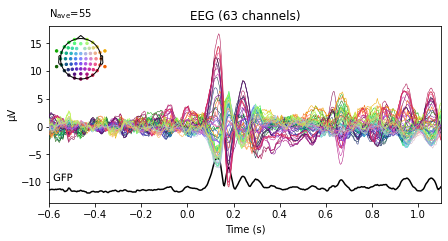

Projections have already been applied. Setting proj attribute to True.


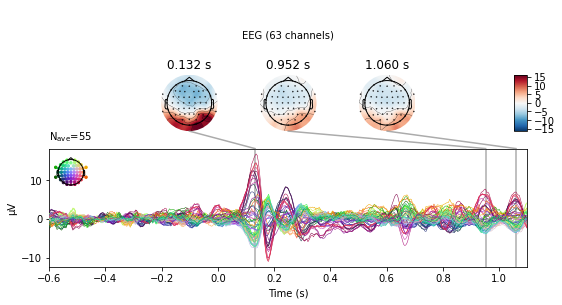



subj01/ses01/img
Reading /content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage(1)/RawData/subj01/ses01/img/epochs-epo.fif ...
    Read a total of 2 projection items:
        EOG-eeg-998--0.200-0.200-PCA-01 (1 x 63) active
        EOG-eeg-998--0.200-0.200-PCA-02 (1 x 63) active
    Found the data of interest:
        t =    -600.00 ...    3100.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
359 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
Subtracting Evoked from Epochs
[done]
Applying baseline correction (mode: mean)


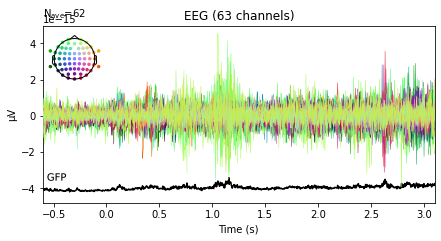

Projections have already been applied. Setting proj attribute to True.


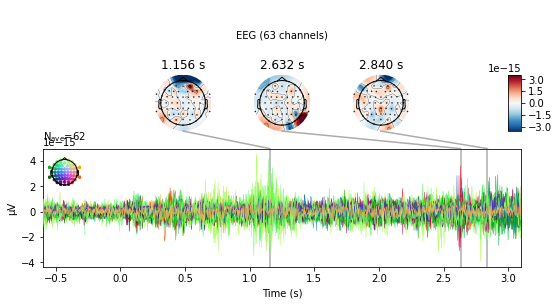

EVENTOS
(62, 3)


subj01/ses02/per
Reading /content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage(1)/RawData/subj01/ses02/per/epochs-epo.fif ...
    Read a total of 2 projection items:
        EOG-eeg-998--0.200-0.200-PCA-01 (1 x 62) active
        EOG-eeg-998--0.200-0.200-PCA-02 (1 x 62) active
    Found the data of interest:
        t =    -600.00 ...    1100.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
420 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)


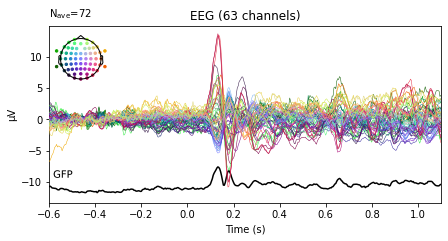

Projections have already been applied. Setting proj attribute to True.


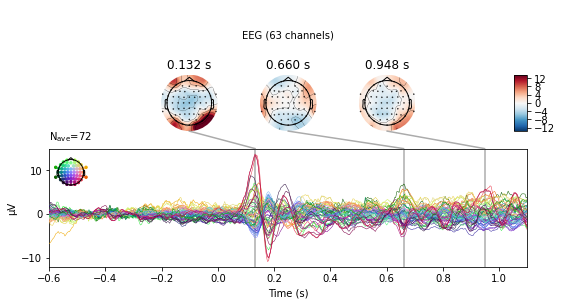



subj01/ses02/img
Reading /content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage(1)/RawData/subj01/ses02/img/epochs-epo.fif ...
    Read a total of 2 projection items:
        EOG-eeg-998--0.200-0.200-PCA-01 (1 x 63) active
        EOG-eeg-998--0.200-0.200-PCA-02 (1 x 63) active
    Found the data of interest:
        t =    -600.00 ...    3100.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
419 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
Subtracting Evoked from Epochs
[done]
Applying baseline correction (mode: mean)


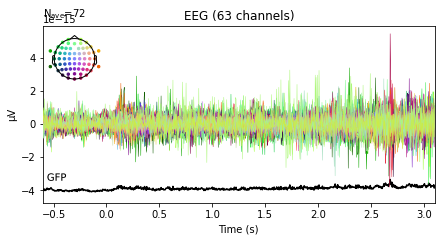

Projections have already been applied. Setting proj attribute to True.


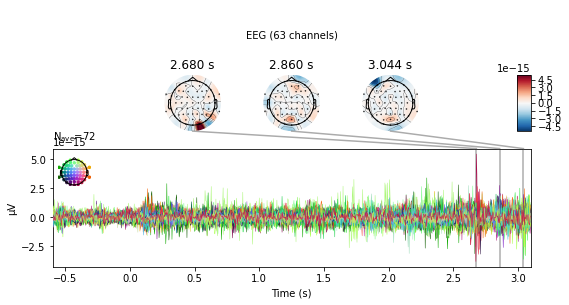

EVENTOS
(72, 3)
Original dataset shape Counter({0: 68, 1: 66})


In [29]:
baseDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/'
trainDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage(1)/RawData/'

# event_dict= {'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 
#                    31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43}
event_dict= {'Pollo': 22, 'Mano': 43}
#channel_select = ['PO7', 'PO3', 'O1', 'O2', 'PO4', 'PO8']

subjects = ['01']
sesions = ['01','02']
tasks = ['per','img']

Xper = []
Ximg = []
yper = []
yimg = []
raw_per = []
raw_img = []
epochs_per = []
epochs_img = []
events_per = []
events_img = []


sfreq= None

for subject in subjects:
  for sesion in sesions:
    for task in tasks:
      print('\n')
      print('subj' + subject + '/' + 'ses' + sesion + '/' + task)
      path_raw_file = baseDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      path_raw_train = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
       

      #raw, Fs, events = extract_raw(path=baseDir_Raw, subject=subject, sesion=sesion, task=task, event_id=event_dict)
      # events, _ = mne.events_from_annotations(raw)
      # raw.filter(l_freq=0.5, h_freq=40,method='iir',iir_params=dict(order=5, ftype='butter', output='sos'))
 
      if task == 'per':
        tmin, tmax = (-0.6, 1.1)  # epoch from 600 ms before event to 1100 ms after it
      if task == 'img':
        tmin, tmax = (-0.6, 3.1)  # epoch from 600 ms before event to 2400 ms after it
    
      # baseline = (-0.2, 0)       # baseline period from start of epoch to time=0
  
  
      # if  sfreq is None:
      #   epochs = mne.Epochs(raw, events, event_dict, tmin, tmax, proj=False,
      #               baseline=baseline, detrend=None, preload=True)
      # else:
      #   epochs = mne.Epochs(raw, events, event_dict, tmin, tmax, proj=False,
      #               baseline=baseline, detrend=None, preload=True).resample(sfreq)# Resample of 1000 Hz to Fs
      #   print('New sampling rate:', epochs.info['sfreq'], 'Hz')
      
      # epochs.filter(l_freq=0.5, h_freq=40,method='iir',iir_params=dict(order=5, ftype='butter', output='sos'))

      epochs = mne.read_epochs(path_raw_train +'epochs-epo.fif', preload=True,proj=False)
      epochs = epochs[list(event_dict.keys())]
      #epochs.filter(l_freq=0.5, h_freq=40,method='iir',iir_params=dict(order=2, ftype='butter', output='sos'))
      # epochs.filter(l_freq=3, h_freq=30,method='iir',iir_params=dict(order=5, ftype='butter', output='sos'))
      #epochs.filter(l_freq=8, h_freq=14,method='fir',n_jobs=-1)
      if task is 'img':
        epochs.subtract_evoked()
        epochs.apply_baseline(baseline=(-0.2,0))
      #epochs.crop(tmin=tmin, tmax=tmax)
      #epochs.pick_channels(ch_names=channel_select)
      #events = np.load(path_raw_train +'events.npy')
      # select = epochs.selection

      evoked = epochs.average()
      evoked.plot(spatial_colors=True, gfp=True)
      evoked.plot_joint()

      X = epochs.get_data()
      # y = events[select,2]
      y = epochs.events[:, 2]
    
      if task is 'per':
        Xper.append(X)
        yper.append(y)
        epochs_per.append(epochs)
        events_per.append(epochs.events)
        #raw_per.append(raw)
      if task is 'img':
        Ximg.append(X)
        yimg.append(y)
        epochs_img.append(epochs)
        events_img.append(epochs.events)
        print('EVENTOS')
        print(epochs.events.shape)
        #raw_img.append(raw)

Xper = np.vstack((Xper[0],Xper[1]))
yper = np.concatenate((yper[0],yper[1]))
Ximg = np.vstack((Ximg[0],Ximg[1]))
yimg = np.concatenate((yimg[0],yimg[1]))

# epochs_per = mne.concatenate_epochs(epochs_per)
# epochs_img = mne.concatenate_epochs(epochs_img)

# first_samps_per = [raw_per[0].first_samp,raw_per[1].first_samp]
# last_samps_per = [raw_per[0].last_samp,raw_per[1].last_samp]
# first_samps_img = [raw_img[0].first_samp,raw_img[1].first_samp]
# last_samps_img = [raw_img[0].last_samp,raw_img[1].last_samp]

# events_per = mne.concatenate_events(events_per,first_samps=first_samps_per, last_samps=last_samps_per)
# events_img = mne.concatenate_events(events_img,first_samps=first_samps_img, last_samps=[717,717])

lper = LabelEncoder()
yper = lper.fit_transform(yper)
limg = LabelEncoder()
yimg = limg.fit_transform(yimg)


print('Original dataset shape %s' % Counter(yimg))

Original dataset shape Counter({0: 68, 1: 66})
Train dataset shape Counter({0: 54, 1: 53})
Test dataset shape Counter({0: 14, 1: 13})
Test dataset len 27
Setting up band-pass filter from 1 - 5 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 1.00, 5.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 6139 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 6741 out of 6741 | elapsed:    2.4s finished


Reduction time
Shape Xnormal:(107, 63, 626)
Reduction time

Select channel from band Delta
{'component_order': 'mutual_info', 'cov_est': 'concat', 'cov_method_params': None, 'log': None, 'n_components': 20, 'norm_trace': False, 'rank': None, 'reg': 'ledoit_wolf', 'transform_into': 'csp_space'}
Computing rank from data with rank=None
    Using tolerance 6.6e-05 (2.2e-16 eps * 63 dim * 4.7e+09  max singular value)
    Estimated rank (mag): 63
    MAG: rank 63 computed from 63 data channels with 0 projectors
Reducing data rank from 63 -> 63
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-05 (2.2e-16 eps * 63 dim * 4.9e+09  max singular value)
    Estimated rank (mag): 63
    MAG: rank 63 computed from 63 data channels with 0 projectors
Reducing data rank from 63 -> 63
Estimating covariance using LEDOIT_WOLF
Done.
[60 20 53 30 50 43 17 39 62 61 32 34 22 40 23 28 48 57  6 11 56 26  5 47
 10 33 51  4 44 52  9 18  1 31 38  8 41 35

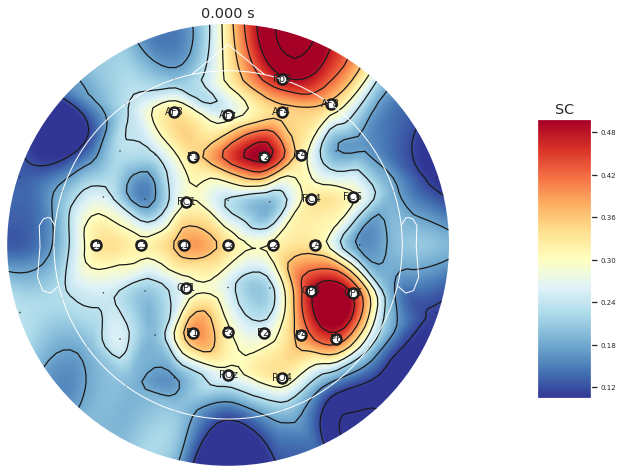

Ouput select channel CSP: (107, 20, 626)
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 20 dim * 3.3e+09  max singular value)
    Estimated rank (mag): 20
    MAG: rank 20 computed from 20 data channels with 0 projectors
Reducing data rank from 20 -> 20
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-05 (2.2e-16 eps * 20 dim * 3.4e+09  max singular value)
    Estimated rank (mag): 20
    MAG: rank 20 computed from 20 data channels with 0 projectors
Reducing data rank from 20 -> 20
Estimating covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 5 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 5.00, 8.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 6380 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 6741 out of 6741 | elapsed:    2.3s finished


Reduction time
Shape Xnormal:(107, 63, 626)
Reduction time

Select channel from band Theta
{'component_order': 'mutual_info', 'cov_est': 'concat', 'cov_method_params': None, 'log': None, 'n_components': 20, 'norm_trace': False, 'rank': None, 'reg': 'ledoit_wolf', 'transform_into': 'csp_space'}
Computing rank from data with rank=None
    Using tolerance 1.9e-05 (2.2e-16 eps * 63 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 63
    MAG: rank 63 computed from 63 data channels with 0 projectors
Reducing data rank from 63 -> 63
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-05 (2.2e-16 eps * 63 dim * 1.3e+09  max singular value)
    Estimated rank (mag): 63
    MAG: rank 63 computed from 63 data channels with 0 projectors
Reducing data rank from 63 -> 63
Estimating covariance using LEDOIT_WOLF
Done.
[30 53 20 50 60 51 62 17 26 23 38 57 11 39  5  0 40 58 61  6 56 27 37 32
 10 22 54  1 34 42 44 14  4 52 48 21 28  9

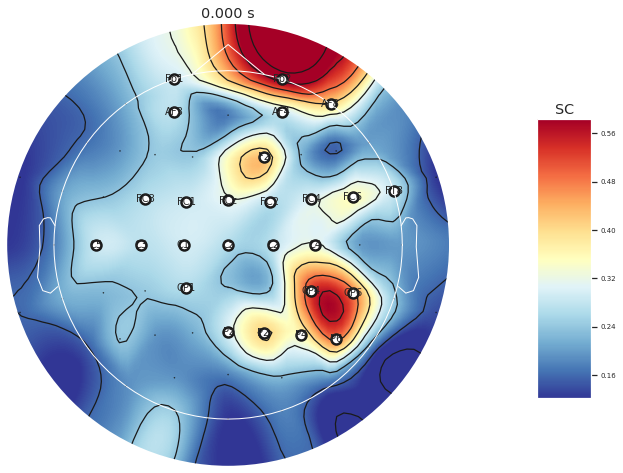

Ouput select channel CSP: (107, 20, 626)
Computing rank from data with rank=None
    Using tolerance 3.4e-06 (2.2e-16 eps * 20 dim * 7.8e+08  max singular value)
    Estimated rank (mag): 20
    MAG: rank 20 computed from 20 data channels with 0 projectors
Reducing data rank from 20 -> 20
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.2e-06 (2.2e-16 eps * 20 dim * 7.3e+08  max singular value)
    Estimated rank (mag): 20
    MAG: rank 20 computed from 20 data channels with 0 projectors
Reducing data rank from 20 -> 20
Estimating covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 8 - 14 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 14.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 6380 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 6741 out of 6741 | elapsed:    2.2s finished


Reduction time
Shape Xnormal:(107, 63, 626)
Reduction time

Select channel from band Alpha
{'component_order': 'mutual_info', 'cov_est': 'concat', 'cov_method_params': None, 'log': None, 'n_components': 20, 'norm_trace': False, 'rank': None, 'reg': 'ledoit_wolf', 'transform_into': 'csp_space'}
Computing rank from data with rank=None
    Using tolerance 4.1e-05 (2.2e-16 eps * 63 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 63
    MAG: rank 63 computed from 63 data channels with 0 projectors
Reducing data rank from 63 -> 63
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-05 (2.2e-16 eps * 63 dim * 3.2e+09  max singular value)
    Estimated rank (mag): 63
    MAG: rank 63 computed from 63 data channels with 0 projectors
Reducing data rank from 63 -> 63
Estimating covariance using LEDOIT_WOLF
Done.
[50 30 32 39 17  0 20 53 40 34 60  5 58  6 56 61  7 57 51 62 21  1 22 27
 33 31 38 11 42 24 23 26 55 37 43 41 44 10

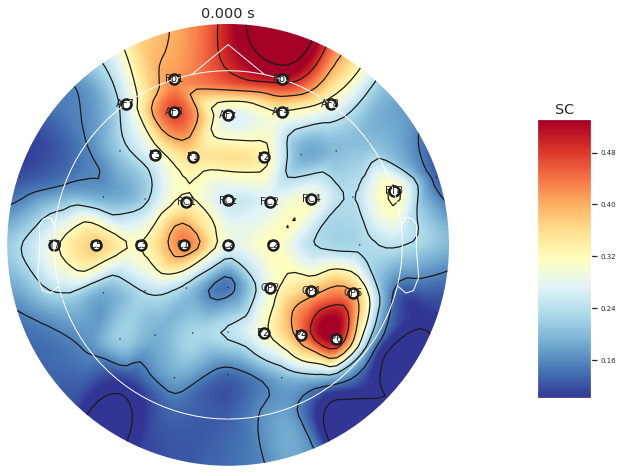

Ouput select channel CSP: (107, 20, 626)
Computing rank from data with rank=None
    Using tolerance 7e-06 (2.2e-16 eps * 20 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 20
    MAG: rank 20 computed from 20 data channels with 0 projectors
Reducing data rank from 20 -> 20
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e-06 (2.2e-16 eps * 20 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 20
    MAG: rank 20 computed from 20 data channels with 0 projectors
Reducing data rank from 20 -> 20
Estimating covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 14 - 31 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 14.00, 31.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 4332 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 6741 out of 6741 | elapsed:    2.1s finished


Reduction time
Shape Xnormal:(107, 63, 626)
Reduction time

Select channel from band Beta
{'component_order': 'mutual_info', 'cov_est': 'concat', 'cov_method_params': None, 'log': None, 'n_components': 20, 'norm_trace': False, 'rank': None, 'reg': 'ledoit_wolf', 'transform_into': 'csp_space'}
Computing rank from data with rank=None
    Using tolerance 2e-05 (2.2e-16 eps * 63 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 63
    MAG: rank 63 computed from 63 data channels with 0 projectors
Reducing data rank from 63 -> 63
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2e-05 (2.2e-16 eps * 63 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 63
    MAG: rank 63 computed from 63 data channels with 0 projectors
Reducing data rank from 63 -> 63
Estimating covariance using LEDOIT_WOLF
Done.
[32 40 34 30  0 23 56 53 57 58 37  7 60 26 50 62 43  5  9 11 42 41 13  6
 27  1 24 20 12 21 51 39 44 52 46 59 55  4 36 2

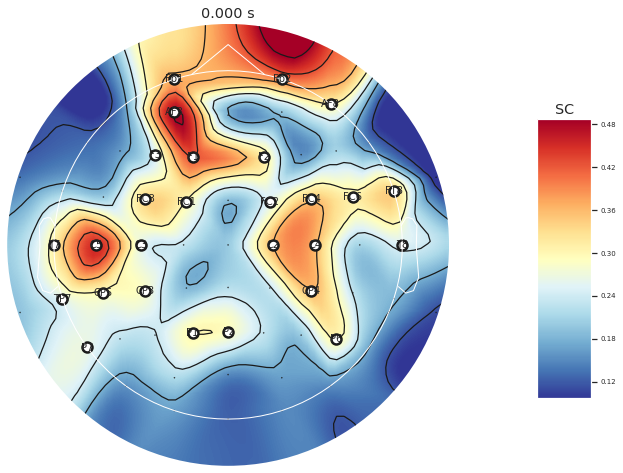

Ouput select channel CSP: (107, 20, 626)
Computing rank from data with rank=None
    Using tolerance 3.3e-06 (2.2e-16 eps * 20 dim * 7.5e+08  max singular value)
    Estimated rank (mag): 20
    MAG: rank 20 computed from 20 data channels with 0 projectors
Reducing data rank from 20 -> 20
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.3e-06 (2.2e-16 eps * 20 dim * 7.4e+08  max singular value)
    Estimated rank (mag): 20
    MAG: rank 20 computed from 20 data channels with 0 projectors
Reducing data rank from 20 -> 20
Estimating covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 31 - 64 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 31.00, 64.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 6380 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 6741 out of 6741 | elapsed:    2.1s finished


Reduction time
Shape Xnormal:(107, 63, 626)
Reduction time

Select channel from band Gamma
{'component_order': 'mutual_info', 'cov_est': 'concat', 'cov_method_params': None, 'log': None, 'n_components': 20, 'norm_trace': False, 'rank': None, 'reg': 'ledoit_wolf', 'transform_into': 'csp_space'}
Computing rank from data with rank=None
    Using tolerance 1.2e-05 (2.2e-16 eps * 63 dim * 8.2e+08  max singular value)
    Estimated rank (mag): 63
    MAG: rank 63 computed from 63 data channels with 0 projectors
Reducing data rank from 63 -> 63
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 63 dim * 8e+08  max singular value)
    Estimated rank (mag): 63
    MAG: rank 63 computed from 63 data channels with 0 projectors
Reducing data rank from 63 -> 63
Estimating covariance using LEDOIT_WOLF
Done.
[56 32 30  0 23 40 57 60 50 26 34  9 62 45 58 27 37 39 55 20  7 24 42 13
 31 41 49 21  1 33 59 14 22 35 18 61 10 15  

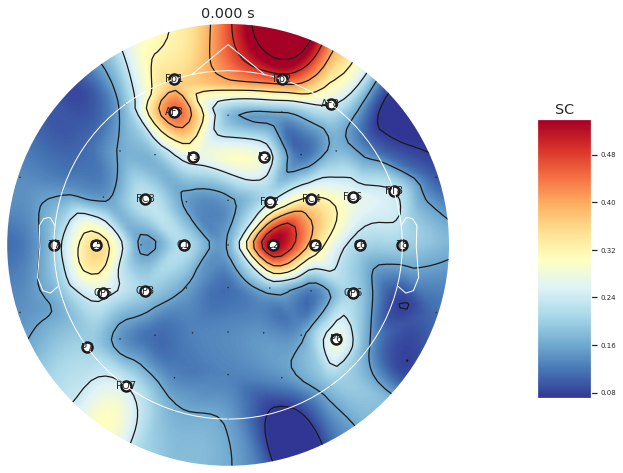

Ouput select channel CSP: (107, 20, 626)
Computing rank from data with rank=None
    Using tolerance 2.2e-06 (2.2e-16 eps * 20 dim * 4.9e+08  max singular value)
    Estimated rank (mag): 20
    MAG: rank 20 computed from 20 data channels with 0 projectors
Reducing data rank from 20 -> 20
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-06 (2.2e-16 eps * 20 dim * 4.9e+08  max singular value)
    Estimated rank (mag): 20
    MAG: rank 20 computed from 20 data channels with 0 projectors
Reducing data rank from 20 -> 20
Estimating covariance using LEDOIT_WOLF
Done.
Setting up band-pass filter from 1 - 5 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 1.00, 5.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1632 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1701 out of 1701 | elapsed:    0.5s finished


Reduction time
Ouput select channel CSP: (27, 20, 626)
Setting up band-pass filter from 5 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 5.00, 8.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1632 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1701 out of 1701 | elapsed:    0.5s finished


Reduction time
Ouput select channel CSP: (27, 20, 626)
Setting up band-pass filter from 8 - 14 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 14.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1632 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1701 out of 1701 | elapsed:    0.6s finished


Reduction time
Ouput select channel CSP: (27, 20, 626)
Setting up band-pass filter from 14 - 31 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 14.00, 31.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 1632 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1701 out of 1701 | elapsed:    0.5s finished


Reduction time
Ouput select channel CSP: (27, 20, 626)
Setting up band-pass filter from 31 - 64 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 31.00, 64.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1632 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1701 out of 1701 | elapsed:    0.5s finished


Reduction time
Ouput select channel CSP: (27, 20, 626)
Setting up band-pass filter from 1 - 5 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 1.00, 5.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1632 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1701 out of 1701 | elapsed:    0.6s finished


Reduction time
Ouput select channel CSP: (27, 20, 626)
Setting up band-pass filter from 5 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 5.00, 8.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1632 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1701 out of 1701 | elapsed:    0.6s finished


Reduction time
Ouput select channel CSP: (27, 20, 626)
Setting up band-pass filter from 8 - 14 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 14.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  52 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1649 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1701 out of 1701 | elapsed:    0.6s finished


Reduction time
Ouput select channel CSP: (27, 20, 626)
Setting up band-pass filter from 14 - 31 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 14.00, 31.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1632 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1701 out of 1701 | elapsed:    0.5s finished


Reduction time
Ouput select channel CSP: (27, 20, 626)
Setting up band-pass filter from 31 - 64 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 31.00, 64.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1632 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1701 out of 1701 | elapsed:    0.5s finished


Reduction time
Ouput select channel CSP: (27, 20, 626)
Score: 0.7777777777777778
Accuracy: 77.77777777777779


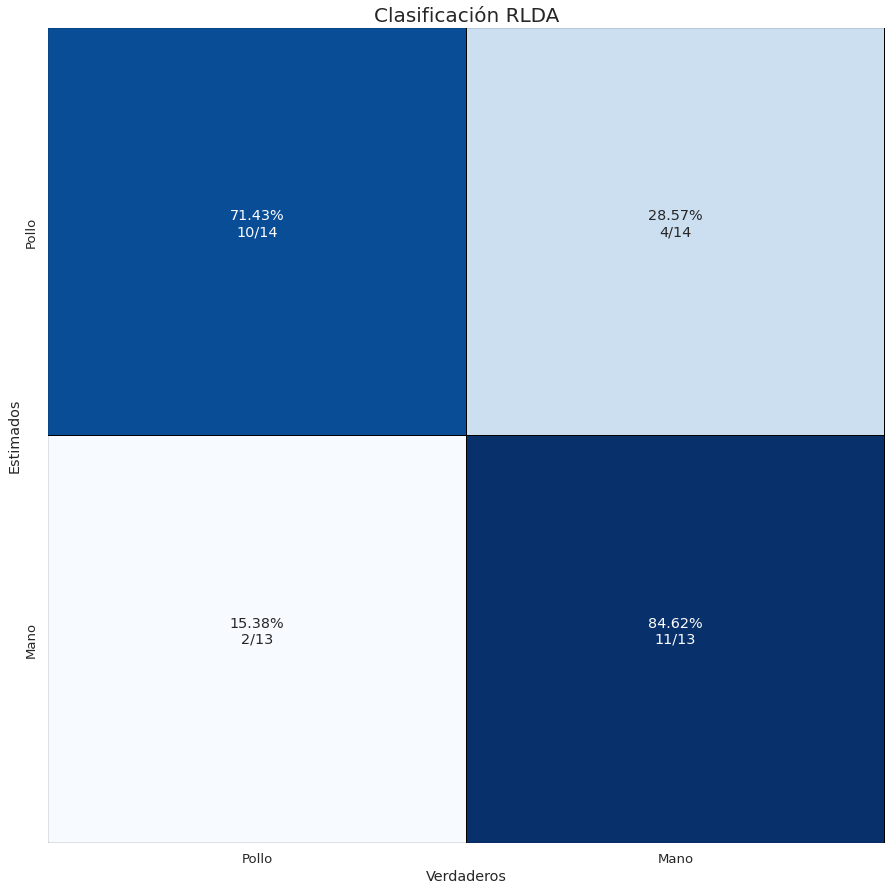

In [34]:
gc.collect()
# classes_dict = {'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 
#                 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43}
event_dict= {'Pollo': 22, 'Mano': 43}
classes_names = event_dict.keys()

ica_total = UnsupervisedSpatialFilter(FastICA(20), average=False)


baselinef=None

filter_delta = Data_Filter(sfreq=epochs.info['sfreq'], l_freq=1, h_freq=5,times=epochs.times, baseline=baselinef, n_jobs=-1) # ('Delta', 1, 4)
filter_theta = Data_Filter(sfreq=epochs.info['sfreq'], l_freq=5, h_freq=8,times=epochs.times, baseline=baselinef, n_jobs=-1) # ('Theta', 5, 7)
filter_alpha = Data_Filter(sfreq=epochs.info['sfreq'], l_freq=8, h_freq=14,times=epochs.times, baseline=baselinef, n_jobs=-1) #('Alpha', 8, 13)
filter_beta = Data_Filter(sfreq=epochs.info['sfreq'], l_freq=14, h_freq=31,times=epochs.times, baseline=baselinef, n_jobs=-1) # ('Beta', 14, 31)
filter_gamma = Data_Filter(sfreq=epochs.info['sfreq'], l_freq=31, h_freq=64,times=epochs.times, baseline=baselinef, n_jobs=-1) #('Gamma', 32, 64)


componentes = 20
reg='ledoit_wolf'
cov_est='concat'
norm_trace=False
component_order='mutual_info'
epochs = epochs_img[0]
sfreq =  epochs.info['sfreq']
t0=-0.6
tmin=0.0
tmax=2.5
transform_into='csp_space'
rank=None


csp = CSP(n_components=componentes, reg=reg, transform_into=transform_into, 
         log=None, cov_est=cov_est, norm_trace=norm_trace, rank=rank, component_order=component_order)
csp_ovr = CSP(n_components=componentes, reg=reg, transform_into=transform_into, 
         log=None, cov_est=cov_est, norm_trace=norm_trace, rank=rank,  component_order='alternate')

csp_delta = CSP(n_components=componentes, reg=reg, transform_into=transform_into, 
         log=None, cov_est=cov_est, norm_trace=norm_trace, rank=rank,  component_order=component_order)
csp_theta = CSP(n_components=componentes, reg=reg, transform_into=transform_into, 
         log=None, cov_est=cov_est, norm_trace=norm_trace, rank=rank,  component_order=component_order)
csp_alpha = CSP(n_components=componentes, reg=reg, transform_into=transform_into, 
         log=None, cov_est=cov_est, norm_trace=norm_trace, rank=rank,  component_order=component_order)
csp_beta = CSP(n_components=componentes, reg=reg, transform_into=transform_into, 
         log=None, cov_est=cov_est, norm_trace=norm_trace, rank=rank,  component_order=component_order)
csp_gamma = CSP(n_components=componentes, reg=reg, transform_into=transform_into, 
         log=None, cov_est=cov_est, norm_trace=norm_trace, rank=rank,  component_order=component_order)


select=20
draw=True
filtre=False
epochs = epochs_img[0]
sfreq =  epochs.info['sfreq']

select_csp = select_channel_csp(epochs, band='full', sfreq=sfreq, csp=csp, 
                select=select, t0=t0, tmin=tmin, tmax=tmax, draw=draw, filtre=filtre)
select_delta = select_channel_csp(epochs, band='Delta', sfreq=sfreq, csp=csp_delta, 
                select=select, t0=t0, tmin=tmin, tmax=tmax, draw=draw, filtre=filtre)
select_theta = select_channel_csp(epochs, band='Theta', sfreq=sfreq, csp=csp_theta, 
                select=select, t0=t0, tmin=tmin, tmax=tmax, draw=draw, filtre=filtre)
select_alpha = select_channel_csp(epochs, band='Alpha', sfreq=sfreq, csp=csp_alpha, 
                select=select, t0=t0, tmin=tmin, tmax=tmax, draw=draw, filtre=filtre)
select_beta = select_channel_csp(epochs, band='Beta', sfreq=sfreq, csp=csp_beta, 
                select=select, t0=t0, tmin=tmin, tmax=tmax, draw=draw, filtre=filtre)
select_gamma = select_channel_csp(epochs, band='Gamma', sfreq=sfreq, csp=csp_gamma, 
                select=select, t0=t0, tmin=tmin, tmax=tmax, draw=draw, filtre=filtre)


reduction = Reduction_Time(sfreq=250, t0=-0.6, tmin=tmin, tmax=tmax)

pca = PCA(n_components=0.95)



rlda = LinearDiscriminantAnalysis(solver='eigen',shrinkage='auto')


clf_delta = make_pipeline(filter_delta,reduction,select_delta,csp_delta)
clf_theta = make_pipeline(filter_theta,reduction,select_theta,csp_theta)
clf_alpha = make_pipeline(filter_alpha,reduction,select_alpha,csp_alpha)
clf_beta = make_pipeline(filter_beta,reduction,select_beta,csp_beta)
clf_gamma= make_pipeline(filter_gamma,reduction,select_gamma,csp_gamma)



estimators = [('clf_delta', clf_delta), ('clf_theta', clf_theta), 
           ('clf_alpha', clf_alpha),('clf_beta', clf_beta),('clf_gamma', clf_gamma)]
combined = FeatureUnion(estimators)
vect = Vectorizer()


X_train, X_test, y_train, y_test = train_test_split(Ximg, yimg, test_size=0.2, random_state=96,stratify=yimg)

clf = make_pipeline(combined,ica_total,vect,pca,rlda) 


print('Original dataset shape %s' % Counter(yimg))
print('Train dataset shape %s' % Counter(y_train))
print('Test dataset shape %s' % Counter(y_test))
print('Test dataset len %s' % len(y_test))



clf.fit(X_train, y_train)
gc.collect()

# clf.fit(X_train, y_train)
score1 = clf.score(X_test, y_test)
y_pred1 = clf.predict(X_test)

print('Score: '+str(score1))
print('Accuracy: '+str(accuracy_score(y_test, y_pred1)*100))
plot_matriz_confusion(y_test, y_pred1, classes_names, save=None, titulo='Clasificación RLDA', figsize=(15,15))
# print(confusion_matrix(y_test, y_pred1))